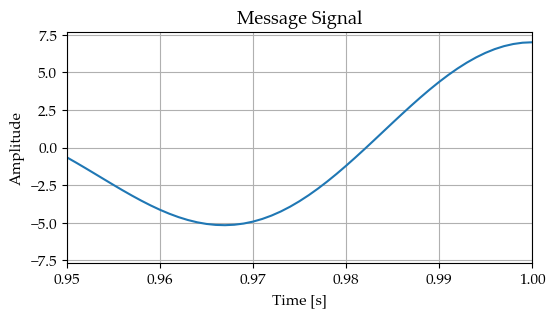

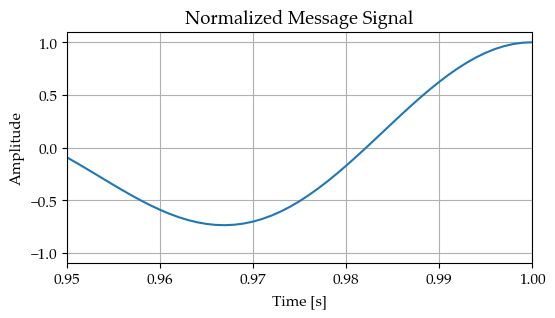

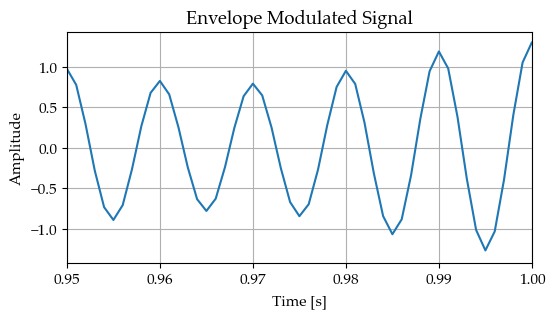

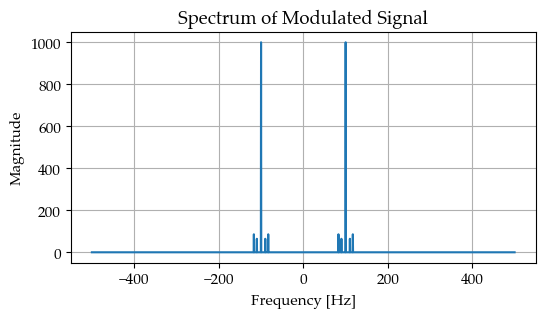

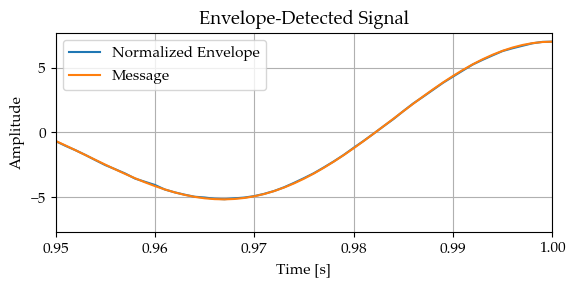

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft, fftshift
from scipy.io import wavfile

plt.rcParams['font.family'] = 'Palatino Linotype'
plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize'] = [6,3]
plt.rcParams['legend.loc'] = 'best'
# enable grid plotting
plt.rcParams['axes.grid'] = True


# Constants and Signal Parameters
fs = 1000  # Sampling frequency (Hz)
fc = 100   # Carrier frequency (Hz)
fm1 = 10    # Message frequency (Hz)
fm2 = 17    # Message frequency (Hz)
mod_index = 0.3  # Modulation index
A1 = 3     # Amplitude of the first sinusoid
A2 = 4     # Amplitude of the second sinusoid
phi1 = 0   # Phase of the first sinusoid
phi2 = 24   # Phase of the second sinusoid
duration = 2  # Duration of the signal in seconds
t = np.arange(0, duration, 1/fs)  # Time vector

# 1. Generate Sinusoidal Message Signal
message = A1 * np.cos(2 * np.pi * fm1 * t + 2 * np.pi * phi1) + A2 * np.cos(2 * np.pi * fm2 * t + 2 * np.pi * phi2)
# fs, message = wavfile.read('audio.wav')
# t = np.arange(0, len(message)/fs, 1/fs)
# fc = 20000

# 2. Perform Envelope Modulation
carrier = np.cos(2 * np.pi * fc * t)
message_normalized = message / np.max(np.abs(message))
modulated_signal = (1 + mod_index * message_normalized) * carrier

# 3. Add AWGN Noise
noise_power = 0.000001  # Noise power
noise = np.sqrt(noise_power) * np.random.normal(size=len(t))
noisy_signal = modulated_signal + noise

# 4. Envelope Detection
envelope = np.abs(hilbert(noisy_signal))

# b, a = butter(4, 8000, 'low', fs=fs)
# envelope = filtfilt(b, a, np.abs(noisy_signal))

envelope_no_offset = envelope - np.mean(envelope)  # Remove DC offset
envelope_normalized = envelope_no_offset / np.max(np.abs(envelope_no_offset)) * np.max(np.abs(message))  # Normalize

# 5. Plotting
# plot the message signal
plt.figure()
plt.plot(t, message)
plt.title('Message Signal')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1])
plt.ylabel('Amplitude')

# plot normalized message signal
plt.figure()
plt.plot(t, message_normalized)
plt.title('Normalized Message Signal')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1])
plt.ylabel('Amplitude')

# Plot the envelope modulated signal
plt.figure()
plt.plot(t, modulated_signal)
plt.title('Envelope Modulated Signal')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1])
plt.ylabel('Amplitude')

# Plot the spectrum
plt.figure()
f = np.linspace(-fs/2, fs/2, len(t))
modulated_spectrum = fftshift(fft(modulated_signal))
plt.plot(f, np.abs(modulated_spectrum))
plt.title('Spectrum of Modulated Signal')
plt.xlabel('Frequency [Hz]')

plt.ylabel('Magnitude')

# Plot the envelope-detected signal after low-pass filtering
plt.figure()
plt.plot(t, envelope_normalized, label='Normalized Envelope')
plt.plot(t, message, label='Message')
plt.title('Envelope-Detected Signal')
plt.xlabel('Time [s]')
plt.xlim([0.95, 1])
plt.ylabel('Amplitude')
plt.tight_layout()
plt.legend()
plt.show()


# write the demodulated signal to a wav file as int16
wavfile.write('am_demodulated.wav', fs, envelope_normalized.astype(np.int16))

# SNR calculation and comparison will be done next.
# modulated_signal, noisy_signal, envelope, modulated_spectrum

In [77]:
def snr(signal, noise):
    """ Calculate Signal-to-Noise Ratio (SNR) """
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = np.mean(np.abs(noise) ** 2)
    return 10 * np.log10(signal_power / noise_power)

# Calculate SNR before detection (pre-detection SNR)
pre_detection_snr = snr(modulated_signal, noise)

# For post-detection SNR, we consider the envelope-detected signal and noise
# Assuming low-pass filter removes most of the high-frequency noise components
post_detection_snr = snr(envelope, noise)

# Theoretical SNR
#?? 这个关系是怎么出来的？？？书上说1.5倍的关系仅适用于Suppress Carrier的AM，这里使用了Envelope Modulation
# For AM, theoretical SNR post-detection is (1.5 * modulation_index^2) times the pre-detection SNR
theoretical_snr_low = 1.5 * (1+mod_index**2) * pre_detection_snr #??
theoretical_snr_high = 1.5 * pre_detection_snr  # For high modulation index close to 1

# theoretical_snr_textbook = 

pre_detection_snr, post_detection_snr, theoretical_snr_low, theoretical_snr_high

#todo: 可以打一个SNR-Noise Power的图，看看SNR和Noise Power的关系

(56.91775778443191, 59.92862780264901, 93.06053397754619, 85.37663667664788)

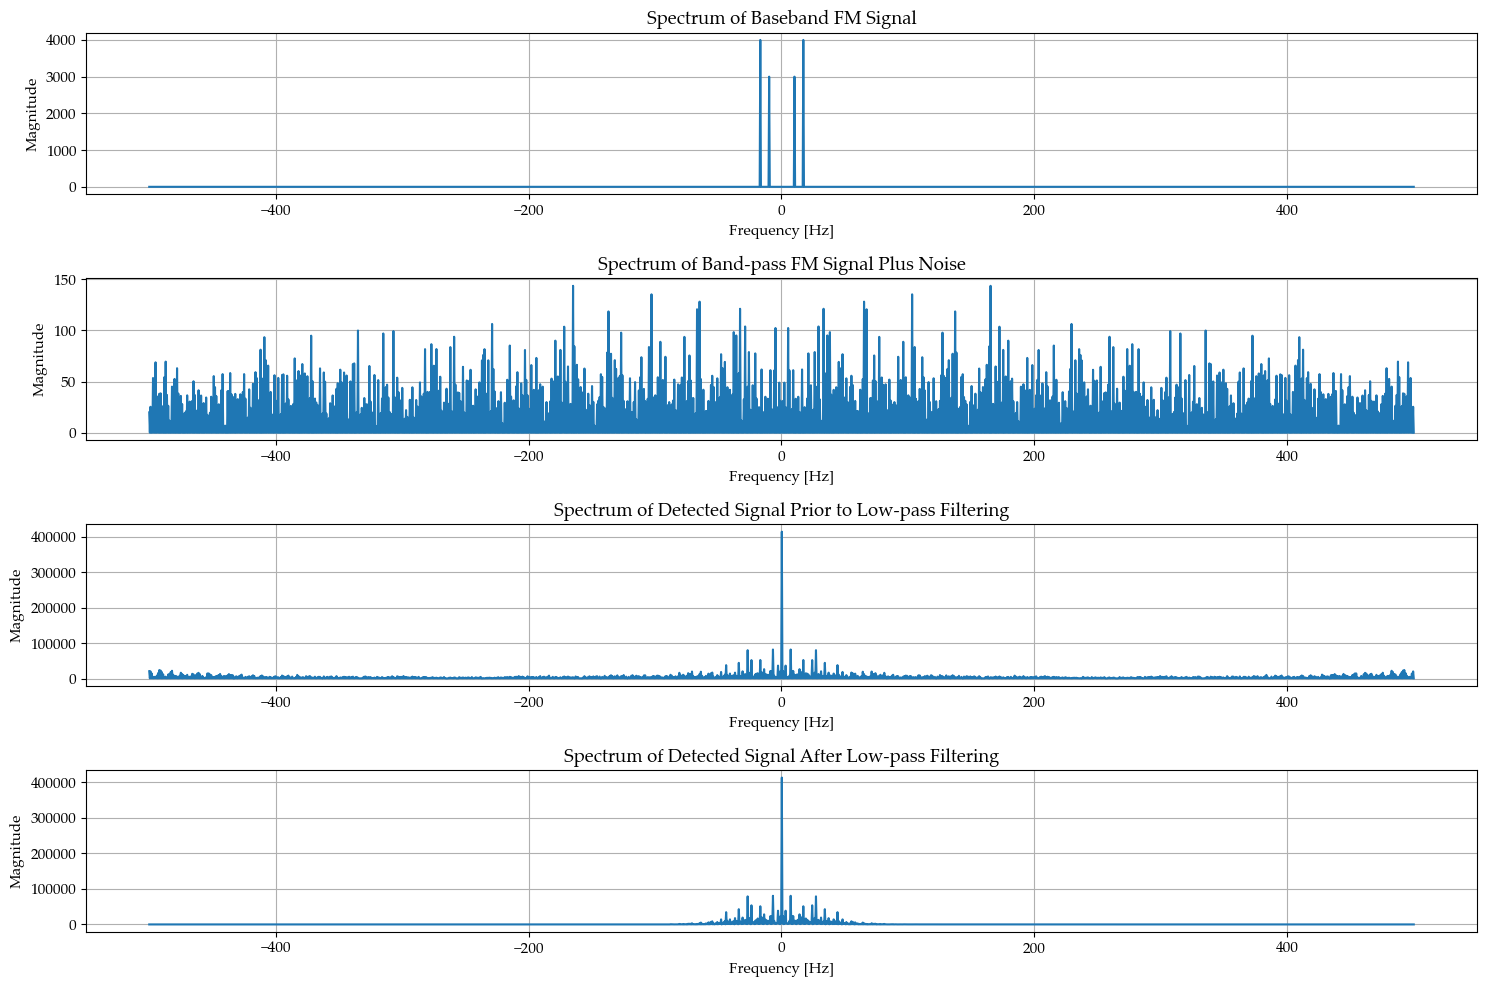

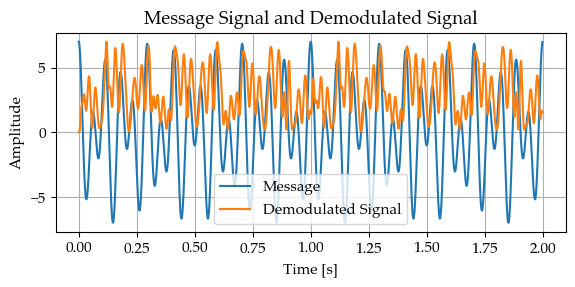

(array([-0.98768834,  0.59867904,  0.08943143, ..., -0.53185534,
        -0.16978553,  0.80901699]),
 array([-0.98757883,  0.59828892,  0.09035861, ..., -0.53210828,
        -0.16898492,  0.81132206]),
 array([316.72694108, 405.68692846, 432.19434565, ..., 380.66438222,
        338.35267907, 338.35267907]),
 array([1.89389346e-02, 1.94416041e-01, 9.89314148e-01, ...,
        1.14254259e+02, 1.11221386e+02, 1.05501305e+02]))

In [86]:
from scipy.signal import butter, lfilter, freqz, hilbert

# Constants and Signal Parameters for FM
deviation = 75  # Frequency deviation in Hz

# 1. Generate Baseband Message Signal (Same as before)
message = A1 * np.cos(2 * np.pi * fm1 * t + 2 * np.pi * phi1) + A2 * np.cos(2 * np.pi * fm2 * t + 2 * np.pi * phi2)

# 2. Perform Frequency Modulation (FM)
integral_of_message = np.cumsum(message) / fs
fm_signal = np.cos(2 * np.pi * fc * t + 2 * np.pi * deviation * integral_of_message)

# 3. Add AWGN Noise
fm_noisy_signal = fm_signal + noise  # Reusing the same noise

# 4. Frequency Demodulation
# For simplicity, using the derivative of the phase of the analytical signal
analytic_signal = hilbert(fm_noisy_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))
instantaneous_frequency = np.diff(instantaneous_phase) * (fs / (2.0 * np.pi))
# demodulated_signal = np.insert(instantaneous_frequency, 0, 0)  # Add a value for t=0
# demodulated_signal += demodulated_signal[-1]  # Add a value for t=0
# append the last value to the end of the numpy array
demodulated_signal = np.append(instantaneous_frequency, instantaneous_frequency[-1])

# Low-pass filter for demodulated signal (for post-detection)
b, a = butter(5, 2*50/fs, btype='low')  # Low-pass filter with a cutoff at 50 Hz
filtered_demodulated_signal = lfilter(b, a, demodulated_signal)
# filtered_demodulated_signal = np.abs(hilbert(demodulated_signal))

filtered_demodulated_signal_normalized = filtered_demodulated_signal / np.max(np.abs(filtered_demodulated_signal)) * np.max(np.abs(message))

# 5. Plots
plt.figure(figsize=(15, 10))

# Spectrum of the baseband FM signal
plt.subplot(4, 1, 1)
baseband_fm_spectrum = fftshift(fft(message))
plt.plot(f, np.abs(baseband_fm_spectrum))
plt.title('Spectrum of Baseband FM Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the band-pass FM signal plus noise
plt.subplot(4, 1, 2)
bandpass_fm_spectrum = fftshift(fft(fm_noisy_signal))
plt.plot(f, np.abs(bandpass_fm_spectrum))
plt.title('Spectrum of Band-pass FM Signal Plus Noise')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the detected signal prior to low-pass filtering
plt.subplot(4, 1, 3)
detected_spectrum_pre_filter = fftshift(fft(demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_pre_filter))
plt.title('Spectrum of Detected Signal Prior to Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

# Spectrum of the detected signal after low-pass filtering
plt.subplot(4, 1, 4)
detected_spectrum_post_filter = fftshift(fft(filtered_demodulated_signal))
plt.plot(f, np.abs(detected_spectrum_post_filter))
plt.title('Spectrum of Detected Signal After Low-pass Filtering')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

# plot the message and the demodulated signal
plt.figure()
plt.plot(t, message, label='Message')
plt.plot(t, filtered_demodulated_signal_normalized, label='Demodulated Signal')
plt.title('Message Signal and Demodulated Signal')
plt.xlabel('Time [s]')
# plt.xlim([0.5, 1])
plt.ylabel('Amplitude')
plt.tight_layout()
plt.legend()
plt.show()


# SNR comparison will be performed next.
fm_signal, fm_noisy_signal, demodulated_signal, filtered_demodulated_signal

In [83]:
# Calculate SNR for FM signals
def snr_fm(signal, noise, fs):
    """ Calculate Signal-to-Noise Ratio (SNR) for FM signals """
    signal_power = np.var(signal)
    noise_power = np.var(noise)
    return 10 * np.log10(signal_power / noise_power)

# Pre-detection SNR for FM
pre_detection_snr_fm = snr_fm(fm_signal, noise, fs)

# Post-detection SNR for FM (after low-pass filtering)
post_detection_snr_fm = snr_fm(filtered_demodulated_signal, noise, fs)

pre_detection_snr_fm, post_detection_snr_fm

(56.74439240038707, 101.68761958284705)